<a href="https://colab.research.google.com/github/Reeshabh45/Sentiment-Analysis/blob/main/sentiment_analysis_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install gensim --upgrade
# !pip install keras --upgrade
# !pip install pandas --upgrade

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
# from keras.preprocessing import Tokenizer
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer, regexp_tokenize
from keras.preprocessing import sequence
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [69]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "/content/drive/MyDrive/Sentiment/model.h5"
WORD2VEC_MODEL = "/content/drive/MyDrive/Sentiment/model.w2v"
TOKENIZER_MODEL = "/content/drive/MyDrive/Sentiment/tokenizer.pkl"
ENCODER_MODEL = "/content/drive/MyDrive/Sentiment/encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [6]:
df=pd.read_csv('/content/drive/MyDrive/tweet1.66.csv', encoding=DATASET_ENCODING, header=None, names=DATASET_COLUMNS)#
df.head()
# df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [9]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 385 ms, sys: 24.6 ms, total: 409 ms
Wall time: 404 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

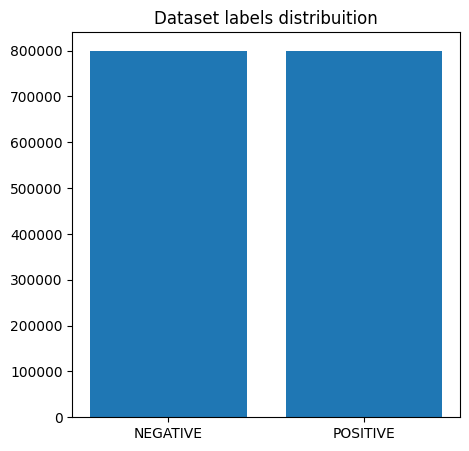

In [88]:
target_cnt = Counter(df.target)

plt.figure(figsize=(5,5))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [12]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 55.6 s, sys: 214 ms, total: 55.8 s
Wall time: 57.5 s


### Split train and test

In [15]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec

In [16]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 3.27 s, sys: 383 ms, total: 3.66 s
Wall time: 3.65 s


In [17]:
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [18]:
w2v_model.build_vocab(documents)

In [19]:
words = w2v_model.wv.index_to_key
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 30369


In [20]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 12min 56s, sys: 4.47 s, total: 13min
Wall time: 7min 46s


(263126302, 295270528)

In [21]:
similar_words = w2v_model.wv.most_similar("love")

print(similar_words)

[('adore', 0.7098693251609802), ('loves', 0.6445099115371704), ('luv', 0.6430889368057251), ('loved', 0.6082940697669983), ('looove', 0.5949455499649048), ('amazing', 0.593874454498291), ('loooove', 0.5887560248374939), ('looooove', 0.5493475198745728), ('loveeee', 0.5475008487701416), ('loveee', 0.5458781123161316)]


### Tokenize Text

In [ ]:
# !pip install tensorflow

In [22]:
%%time

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290419
CPU times: user 17.5 s, sys: 220 ms, total: 17.7 s
Wall time: 17.8 s


In [23]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 22.7 s, sys: 505 ms, total: 23.2 s
Wall time: 23.4 s


### Label Encoder

In [25]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print('\n')
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)


x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

### Embedding layer

In [29]:
w2v_model.vector_size

100

In [30]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 100)


In [31]:
# embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
import tensorflow as tf
!pip install keras
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          W2V_SIZE,
                                          weights=[embedding_matrix],
                                          input_length=SEQUENCE_LENGTH,
                                          trainable=False)

### Build Model

In [43]:
model = Sequential()
model.add(embedding_layer)
# model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50,  activation='relu'))
# model.add(Dense(50,  activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          29041900  
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 29127401 (111.11 MB)
Trainable params: 85501 (333.99 KB)
Non-trainable params: 29041900 (110.79 MB)
_________________________________________________________________


### Compile model

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [45]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [46]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=5,
                    validation_split=0.1,
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/5
1125/1125 - 468s - loss: 0.4772 - accuracy: 0.7686 - val_loss: 0.4530 - val_accuracy: 0.7845 - lr: 0.0010 - 468s/epoch - 416ms/step
Epoch 2/5
1125/1125 - 476s - loss: 0.4548 - accuracy: 0.7828 - val_loss: 0.4458 - val_accuracy: 0.7885 - lr: 0.0010 - 476s/epoch - 423ms/step
Epoch 3/5
1125/1125 - 474s - loss: 0.4478 - accuracy: 0.7869 - val_loss: 0.4425 - val_accuracy: 0.7909 - lr: 0.0010 - 474s/epoch - 421ms/step
Epoch 4/5
1125/1125 - 475s - loss: 0.4437 - accuracy: 0.7891 - val_loss: 0.4410 - val_accuracy: 0.7920 - lr: 0.0010 - 475s/epoch - 422ms/step
Epoch 5/5
1125/1125 - 479s - loss: 0.4405 - accuracy: 0.7911 - val_loss: 0.4395 - val_accuracy: 0.7928 - lr: 0.0010 - 479s/epoch - 426ms/step
CPU times: user 42min 55s, sys: 1min 37s, total: 44min 32s
Wall time: 39min 34s


### Evaluate

In [47]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 28s 89ms/step - loss: 0.4384 - accuracy: 0.7936

ACCURACY: 0.7935624718666077
LOSS: 0.4384395480155945
CPU times: user 27.9 s, sys: 657 ms, total: 28.5 s
Wall time: 41.9 s


10000/10000 [==============================] - 912s 91ms/step - loss: 0.4384 - accuracy: 0.7936


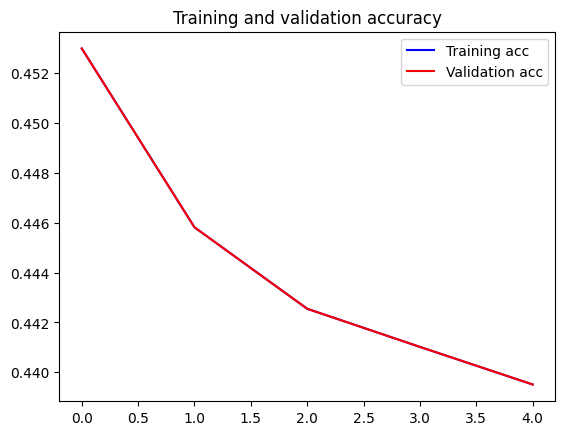

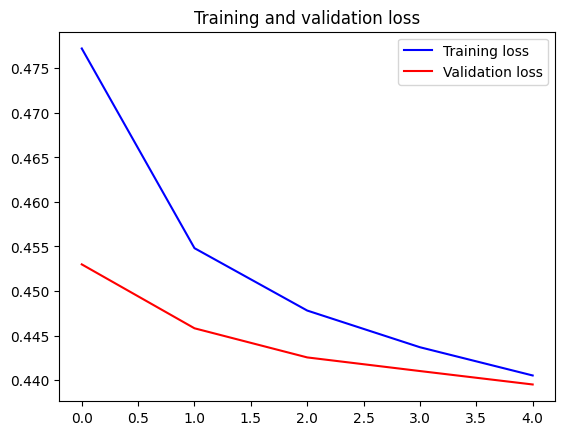

In [49]:
acc = history.history['val_loss']
val_acc = model.evaluate(x_test, y_test)[1]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Confusion Matrix

In [55]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 15s 369ms/step
CPU times: user 10.4 s, sys: 5.77 s, total: 16.2 s
Wall time: 21.6 s


In [56]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

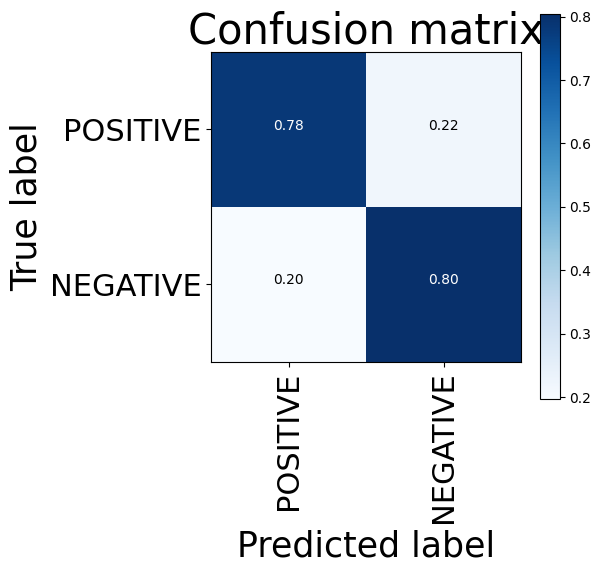

CPU times: user 2.06 s, sys: 172 ms, total: 2.23 s
Wall time: 3.43 s


In [79]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [58]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [59]:
accuracy_score(y_test_1d, y_pred_1d)

0.7935625

### Save model

In [70]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Predict

In [71]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Sentiment/model.h5')

In [73]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [74]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
            "elapsed_time": time.time()-start_at}


Enter the text you want to analyze: love me
1/1 [==============================] - 0s 278ms/step
Predicted sentiment: POSITIVE with a score of 0.8624717593193054
Elapsed time: 0.37584686279296875 seconds


In [65]:
predict("Amidst the symphony of challenges, she orchestrated a resilient melody of triumph, turning adversity into an opulent tapestry of success")

1/1 [==============================] - 0s 159ms/step


{'label': 'POSITIVE',
 'score': 0.9419005513191223,
 'elapsed_time': 0.2304384708404541}

In [66]:
predict("The stormy clouds of despair hung heavily over his shattered dreams.")

1/1 [==============================] - 0s 339ms/step


{'label': 'NEGATIVE',
 'score': 0.15910379588603973,
 'elapsed_time': 0.46959686279296875}

In [67]:
predict("In the labyrinth of desolation, the echoes of shattered hopes reverberated, casting a gloom that clung to the fractured fragments of a once-vibrant existence.")

1/1 [==============================] - 0s 87ms/step


{'label': 'NEGATIVE',
 'score': 0.18520404398441315,
 'elapsed_time': 0.13040566444396973}

In [75]:
if __name__ == "__main__":
    user_input = input("Enter the text you want to analyze: ")
    result = predict(user_input)
    print(f"Predicted sentiment: {result['label']} with a score of {result['score']}")
    print(f"Elapsed time: {result['elapsed_time']} seconds")

Enter the text you want to analyze: The stormy clouds of despair hung heavily over his shattered dreams.
1/1 [==============================] - 0s 86ms/step
Predicted sentiment: NEGATIVE with a score of 0.15910379588603973
Elapsed time: 0.1299607753753662 seconds
